In [1]:
import sys
sys.path.insert(0,'/home/ekoehn/software/')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib

import hysteresis
from hysteresis import hyst_areas as ha
importlib.reload(ha)

<module 'hysteresis.hyst_areas' from '/home/ekoehn/software/hysteresis/hyst_areas.py'>

In [2]:
# Define dimensions
n_years = 180
n_lat = 50
n_lon = 100

# Generate coordinate arrays
years = np.arange(n_years)
lats = np.linspace(-90, 90, n_lat)
lons = np.linspace(-180, 180, n_lon)

# Create a meshgrid of lat/lon to generate unique sinusoidal patterns at each location
lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')

# Generate a unique sinusoidal signal at each (lat, lon) location
# The phase and amplitude vary slightly per location for uniqueness
amplitudes = 1 + 0.5 * np.sin(np.radians(lat_grid))  # Amplitude varies with latitude
phases = np.radians(lon_grid)  # Phase shift varies with longitude

# Create the time-dependent data
data = np.array([
    amplitudes * np.sin(2 * np.pi * years[i] / n_years + phases)
    for i in range(n_years)
])

# Convert to an xarray DataArray
da = xr.DataArray(
    data,
    coords={"year": years, "lat": lats, "lon": lons},
    dims=["year", "lat", "lon"]
)

In [3]:
ref_axis = np.sin(np.linspace(-np.pi/2,3/2*np.pi,n_years)) # strictly monotonically increasing and then strictly monotonically decreasing reference axis over a 2pi cycle


Text(0.5, 1.0, 'Data series vs. ref. axis')

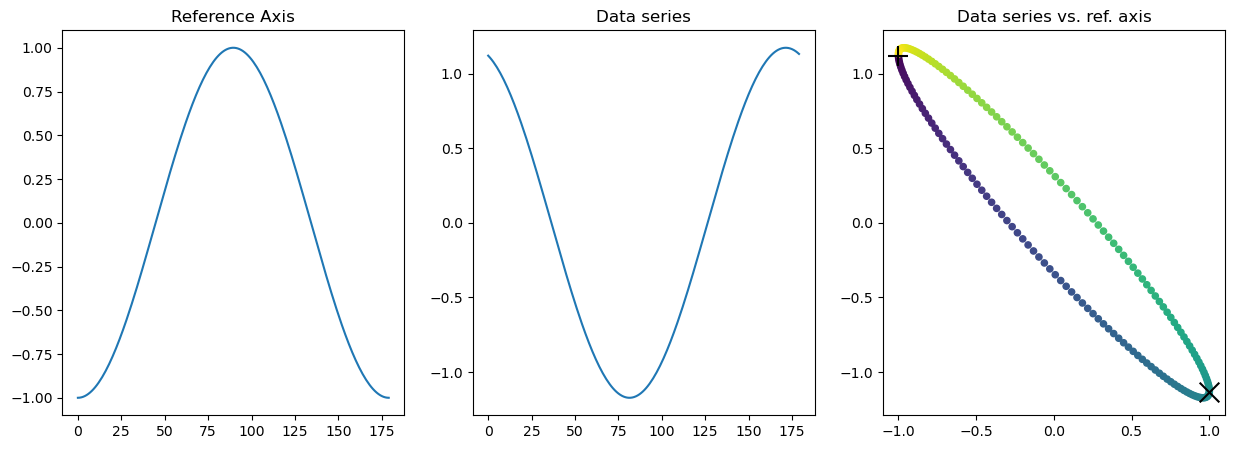

In [4]:
data_series = da.isel(lat=-20,lon=-21)
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(ref_axis)
ax[0].set_title('Reference Axis')
ax[1].plot(data_series)
ax[1].set_title('Data series')
ax[2].scatter(ref_axis,data_series,20,np.arange(n_years))
#find argmax of ref_axis
argmini = np.argmin(ref_axis)
argmaxi = np.argmax(ref_axis)
ax[2].scatter(ref_axis[argmini],data_series[argmini],200,'k',marker='+')
ax[2].scatter(ref_axis[argmaxi],data_series[argmaxi],200,'k',marker='x')
ax[2].set_title('Data series vs. ref. axis')

## Do the calculation of the hysteresis area and return the interpolated vectors etc.

In [5]:
normalizer = 'min_max_diff_full_cycle'
ds = ha.calc_hysteresis_area_3D(ref_axis, data_series, nsteps=1000, normalizer=normalizer)
#hysteresis_area, signed_hysteresis_area, normalized_hysteresis_area, normalizer_value,interpolated_rampup, interpolated_rampdown, ramping_vector = result

/home/ekoehn/software/hysteresis/hyst_areas.py:46: RuntimeWarning: Reference axis does not have a single clear peak. Results may be unreliable.
  warnings.warn("Reference axis does not have a single clear peak. Results may be unreliable.", RuntimeWarning)


ValueError: different number of dimensions on data and dims: 0 vs 2

In [43]:
# Create a test DataArray (random values for testing)
years = np.arange(2000, 2010)  # Example year range
latitudes = np.arange(0, 3)  # 3 latitude points
longitudes = np.arange(0, 4)  # 4 longitude points

# Create a DataArray with shape (10, 3, 4), i.e., 10 years, 3 latitudes, 4 longitudes
data = np.random.rand(10, 3, 4)  # Random values between 0 and 1
da = xr.DataArray(data, dims=["year", "lat", "lon"], coords={"year": years, "lat": latitudes, "lon": longitudes})

# Apply mean along the 'year' dimension using apply_ufunc
mean_result = xr.apply_ufunc(
    np.mean,  # The function to apply
    da,  # The DataArray to apply the function on
    input_core_dims=[["year"]],  # The dimension to apply the function along (here it's "year")
    output_core_dims=[[]],  # The output dimensions (after mean, it will be over lat and lon)
    vectorize=True,  # Apply element-wise across lat/lon
)

# Check the result
print(mean_result)

<xarray.DataArray (lat: 3, lon: 4)>
array([[0.68780785, 0.48874672, 0.45096313, 0.38933456],
       [0.36612023, 0.48838712, 0.54649721, 0.46315367],
       [0.60371189, 0.48270241, 0.5885605 , 0.5507463 ]])
Coordinates:
  * lat      (lat) int64 0 1 2
  * lon      (lon) int64 0 1 2 3
